# Pneumonia Detection

In [ ]:
!pip install kaggle
!pip install tensorflow

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import numpy as np
import shutil
import os

TRAIN_PATH = "/content/drive/MyDrive/tesis/pruebat/prueba/train"
VAL_PATH = "/content/drive/MyDrive/tesis/pruebat/prueba/val"
VAL_SIZE = 0.2

labels = ['BAC_PNEUMONIA', 'NORMAL', 'VIR_PNEUMONIA']
train_bac = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[0])+'/*.jpeg'))
train_normal = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[1])+'/*.jpeg'))
train_viral = sorted(tf.io.gfile.glob(os.path.join(TRAIN_PATH, labels[2])+'/*.jpeg'))

rng = np.random.RandomState(42)
rng.shuffle(train_bac)
rng.shuffle(train_normal)
rng.shuffle(train_viral)

for i, train_files in enumerate([train_bac, train_normal, train_viral]):
  val_split = int(len(train_files)*VAL_SIZE)
  train_files = train_files[:val_split]
  for train_file in train_files:
    file_path = os.path.join(VAL_PATH, labels[i])
    shutil.move(train_file, file_path)


## Image Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def generate_image():
    TRAINING_DIR = "/content/drive/MyDrive/tesis/pruebat/prueba/train"
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        shear_range=0.2,
        zoom_range=0.2,
        height_shift_range=0.2,
        width_shift_range=0.2,
        fill_mode="nearest",
        horizontal_flip=True,
        vertical_flip=True,
    )

    train_generator = train_datagen.flow_from_directory(
        TRAINING_DIR,
        target_size=(224, 224),
        batch_size=64,
        class_mode="categorical",
        color_mode='rgb',
    )

    VALIDATION_DIR = "/content/drive/MyDrive/tesis/pruebat/prueba/val"
    validation_datagen = ImageDataGenerator(rescale=1./255)

    validation_generator = validation_datagen.flow_from_directory(
        VALIDATION_DIR,
        target_size=(224, 224),
        batch_size=16,
        class_mode="categorical",
        color_mode='rgb',
    )

    return train_generator, validation_generator


In [ ]:
generate_image()[0].class_indices

Found 291 images belonging to 3 classes.
Found 3857 images belonging to 3 classes.


{'BAC_PNEUMONIA': 0, 'NORMAL': 1, 'VIR_PNEUMONIA': 2}

## Modeling with DenseNet

In [ ]:
"""
conv_base = DenseNet201(include_top=False, weights='imagenet',
                       input_shape=(224,224,3))
conv_base.summary()
"""

"\nconv_base = DenseNet201(include_top=False, weights='imagenet',\n                       input_shape=(224,224,3))\nconv_base.summary()\n"

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.regularizers import L2
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
import tensorflow as tf

conv_base = DenseNet201(
    include_top=False,
    weights='imagenet',
    input_tensor=Input(shape=(224,224,3))
)

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block1_2_conv':
        set_trainable = True
    layer.trainable = set_trainable

x = conv_base.output
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=L2(0.1))(x)
outputs = layers.Dense(3, activation='softmax')(x)

model = Model(inputs=conv_base.input, outputs=outputs)

optimizer = Adam()
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=[
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.CategoricalAccuracy(name='acc')
    ]
)


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d_2… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_3… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 42,407,491 (161.77 MB)

 Trainable params: 30,951,171 (118.07 MB)

 Non-trainable params: 11,456,320 (43.70 MB)

## Training

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self,
               desired_acc=0.5):
    self.desired_acc = desired_acc

  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>self.desired_acc):
      print(f"\nReached {self.desired_acc} accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

train_generator, validation_generator = generate_image()

callbacks = myCallback()
history = model.fit(train_generator,
                    epochs=50,
                    verbose=1,
                    validation_data=validation_generator)

Found 291 images belonging to 3 classes.
Found 3857 images belonging to 3 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 291s 44s/step - acc: 0.3779 - auc: 0.5456 - loss: 64.6652 - precision: 0.3879 - recall: 0.3513 - val_acc: 0.5528 - val_auc: 0.6771 - val_loss: 31.4845 - val_precision: 0.5528 - val_recall: 0.5528
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 90s 22s/step - acc: 0.5641 - auc: 0.6789 - loss: 26.5711 - precision: 0.5654 - recall: 0.5641 - val_acc: 0.4426 - val_auc: 0.6897 - val_loss: 25.5141 - val_precision: 0.4425 - val_recall: 0.4421
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 89s 22s/step - acc: 0.5040 - auc: 0.7748 - loss: 22.5239 - precision: 0.5052 - recall: 0.5040 - val_acc: 0.6054 - val_auc: 0.7602 - val_loss: 21.6522 - val_precision: 0.6082 - val_recall: 0.5992
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 89s 22s/step - acc: 0.7555 - auc: 0.8596 - loss: 18.8127 - precision: 0.7615 - recall: 0.7555 - val_acc: 0.5450 - val_auc: 0.7301 - val_loss: 17.5337 - val_precision: 0.5466 - val_recall: 0.5408
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 60s 14s/step - acc: 0.7678 - auc: 0.913

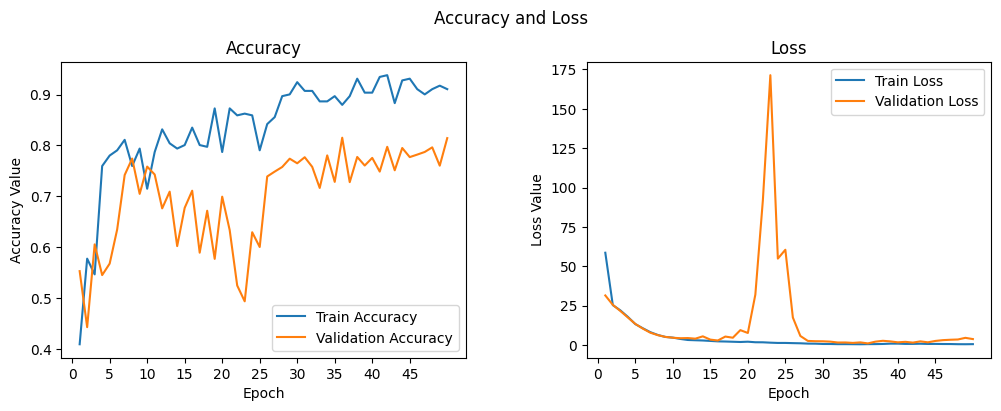

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Accuracy and Loss', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = 50
epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Plot Confusion Matrix

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TEST_DIR = "/content/drive/MyDrive/tesis/pruebat/prueba/test"

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=1,
    class_mode="categorical",
    color_mode='rgb',
    shuffle=False,
)


Found 300 images belonging to 3 classes.


In [ ]:
import numpy as np

filenames = test_generator.filenames
nb_samples = len(filenames)

predictions = model.predict(test_generator, steps = nb_samples)
y_pred = np.rint(predictions)
y_pred = tf.argmax(y_pred, axis=1)

y_true = test_generator.classes

300/300 ━━━━━━━━━━━━━━━━━━━━ 29s 27ms/step


In [ ]:
y_pred

<tf.Tensor: shape=(300,), dtype=int64, numpy=
array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 1, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 1,
       1, 2, 1, 1, 2, 1, 1, 2, 1, 2, 1, 2, 0, 0, 1, 1, 2, 1, 2, 2, 1, 2,
       2, 1, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
     

In [ ]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2], d

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=60)
    plt.yticks(tick_marks, classes, fontsize=60)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=60)

    plt.ylabel('True label', fontsize=60)
    plt.xlabel('Predicted label', fontsize=60)

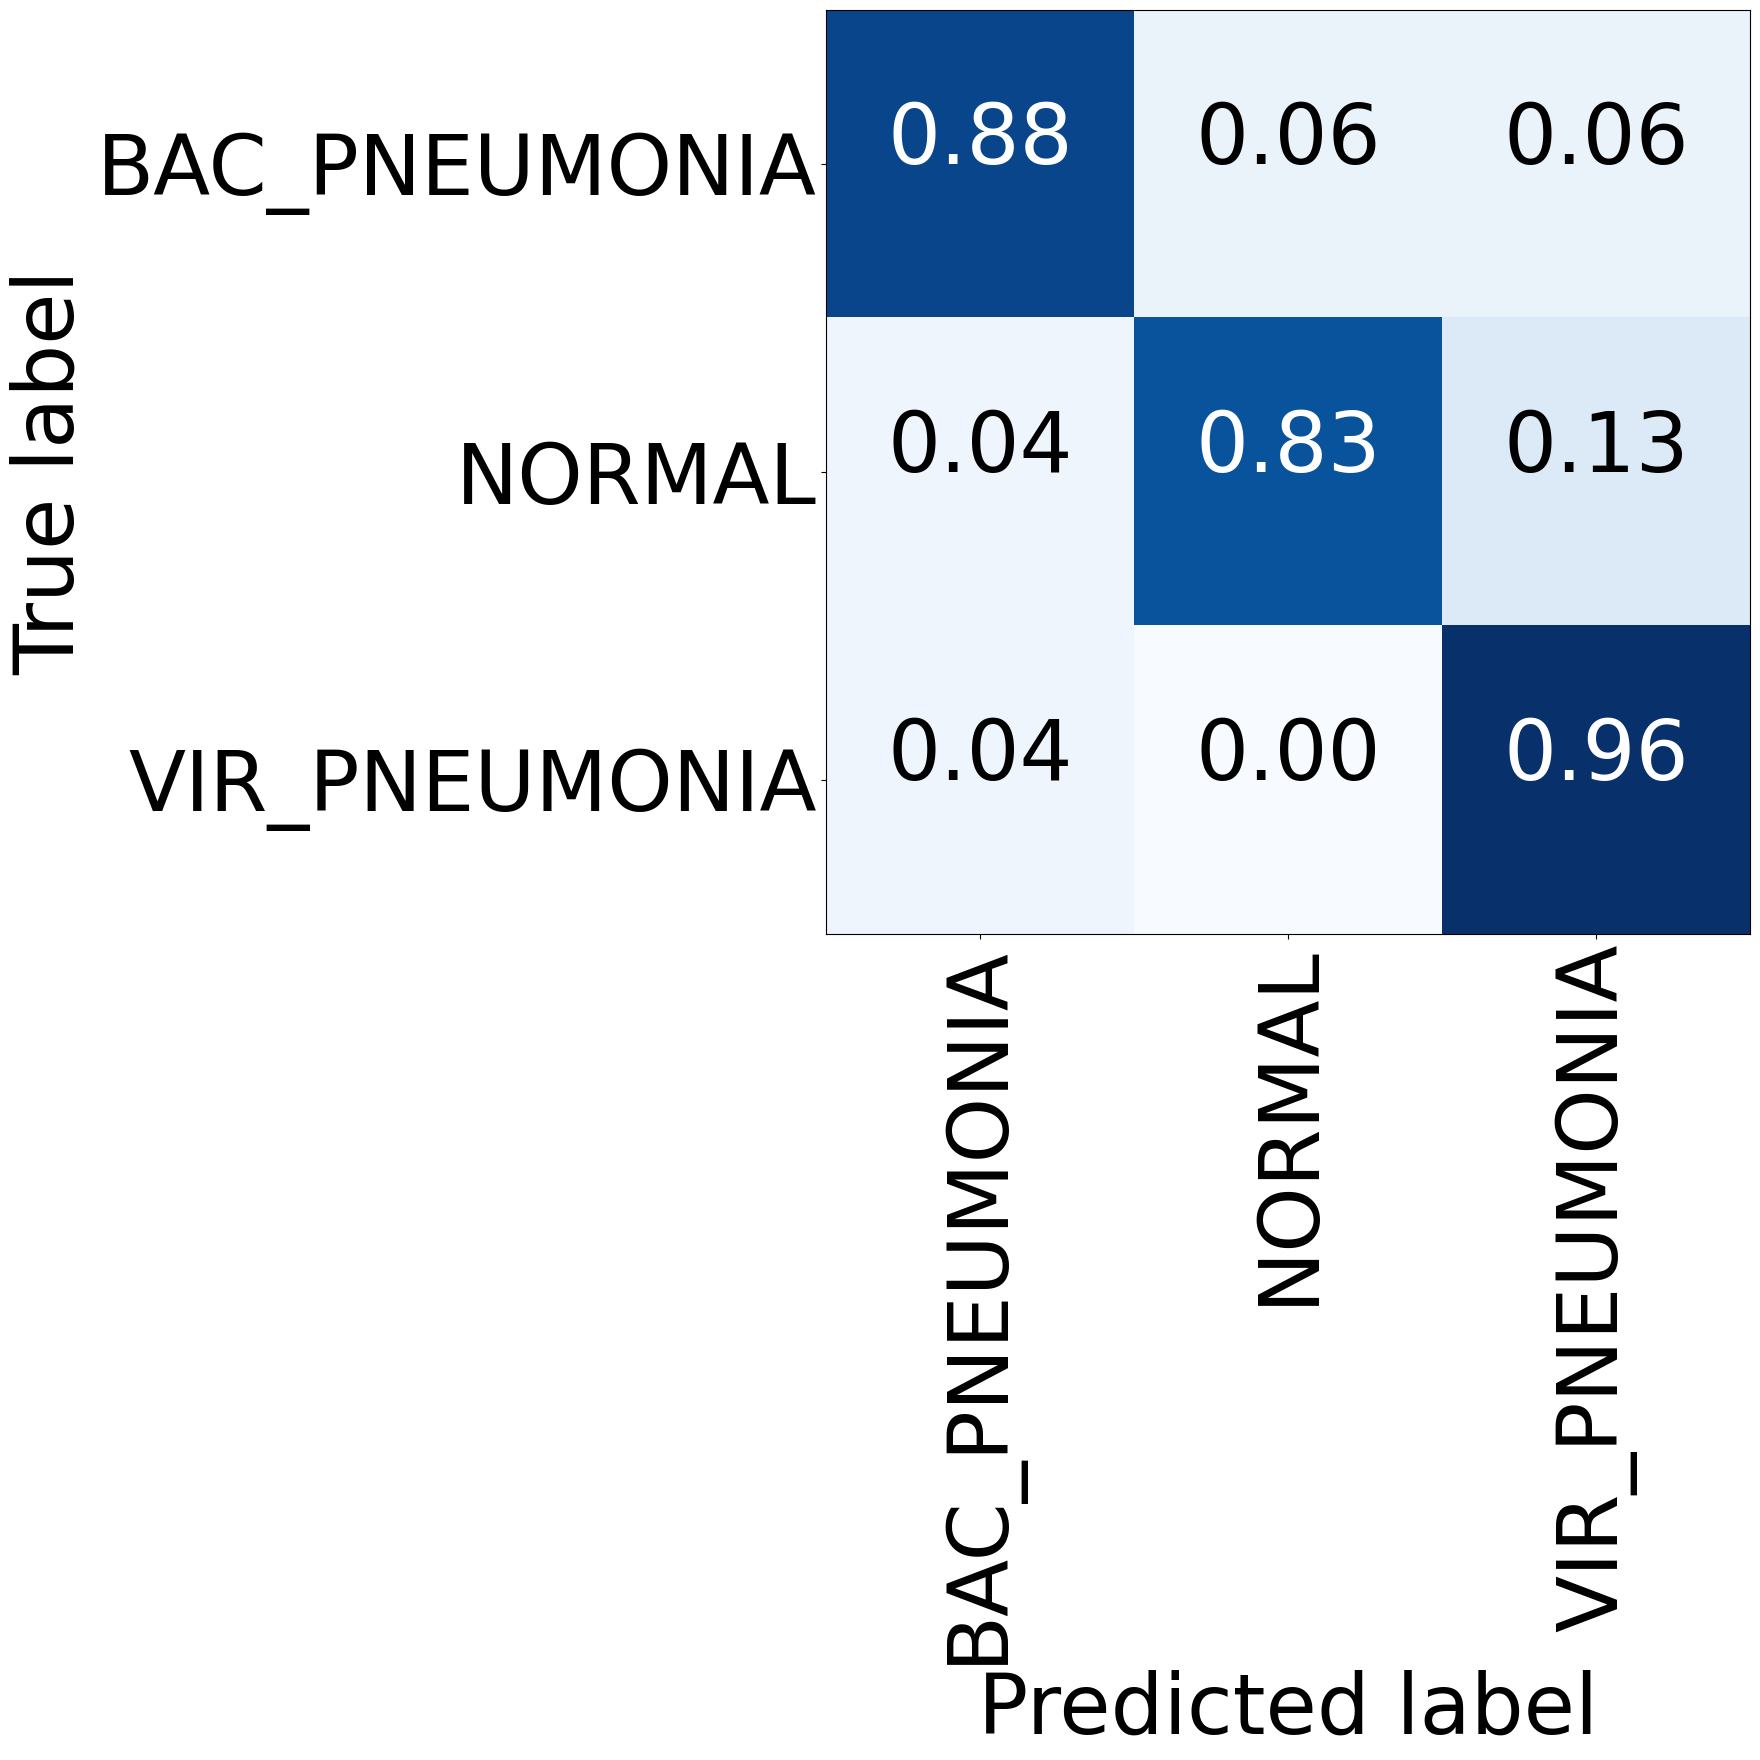

In [ ]:
import matplotlib.pyplot as plt

cnf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=test_generator.class_indices.keys(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.92      0.88      0.90       100
           1       0.93      0.83      0.88       100
           2       0.83      0.96      0.89       100

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



In [ ]:
model.evaluate(test_generator)

300/300 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - acc: 0.8682 - auc: 0.9571 - loss: 0.8663 - precision: 0.8695 - recall: 0.8682


[0.920724093914032,
 0.8929765820503235,
 0.8899999856948853,
 0.9601944088935852,
 0.8899999856948853]

## Save Model

In [ ]:
model.save("DN.keras")